# Deporvillage use case

__INDEX__

1. Load and inspect data  
	- Sanity checks
	- Aggragate at the Brand/Family level
2. Inspect columns
3. Time series and aggregations 
	- Revenues and quantities
	- Seasonalities
	- Families

  


---
**OPTION 1**: Predict Quantity at Brand + Family Level, then Convert to Revenue  

1.	Aggregate historical quantity sold at (brand, family, date).
2.	Predict total quantity for the future period. Target Variable: total_quantity per brand/family for the forecast period.
3.	Convert to revenue using an estimated PVP per (brand, family), such as a Weighted PVP based on sales distribution:
$$\text{avg\_pvp} = \frac{\sum (\text{quantity} \times \text{pvp})}{\sum \text{quantity}}$$



- Pros:  
	•	More granular, allowing adjustments based on price changes.  
	•	If PVP changes, we can easily recalculate revenue.  

- Cons:  
	•	Requires an extra step and assumes PVP remains constant or follows a simple trend.    

This is probably better is PVP fluctuates.  

---
**OPTION 2**: Directly Predict Revenue (Sales)  

Target Variable: $\text{total revenue} = \text{total quantity sold} × PVP$  

1.	Aggregate historical revenue at (brand, family, date).
2.	Predict total revenue for the future period. 

- Pros:  
	•	Simpler approach with fewer calculations.
	•	Directly aligns with the budgeting goal.  
    •   No need to worry about varying PVP within a brand + family.

- Cons:  
	•	If prices fluctuate, the model won’t capture it properly.  
	•	Less flexibility—harder to analyze quantity vs. price effects separately.  

Assumes PVP is stable.

## 1. Load and inspect data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import utils.utils_plots as utils_plots
from utils.utils_features_family import ExtractFamilyFeatures

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [3]:
df.head()

,product_id,fecha,store,quantity,seasonality,brand,family,pvp
0,883A4A2507184C5483FDC9FC7E48240B,2021-03-22,FR,1.0,N-A,adidas,Zapatillas Trail Running,130.0
1,883A4A2507184C5483FDC9FC7E48240B,2021-03-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.0
2,883A4A2507184C5483FDC9FC7E48240B,2021-08-27,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.0
3,883A4A2507184C5483FDC9FC7E48240B,2021-06-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.0
4,883A4A2507184C5483FDC9FC7E48240B,2021-03-05,IT,1.0,N-A,adidas,Zapatillas Trail Running,130.0


### Sanity checks

In [4]:
# All products have a unique PVP, seasonality, brand and family (as expected)
assert (df.groupby('product_id')['pvp'].nunique() != 1).sum() == 0
assert (df.groupby('product_id')['seasonality'].nunique() != 1).sum() == 0
assert (df.groupby('product_id')['brand'].nunique() != 1).sum() == 0
assert (df.groupby('product_id')['family'].nunique() != 1).sum() == 0

assert (df['quantity']>=0).all()
assert (df['pvp']>=0).all()

### Aggragate at the Brand/Family level

In [5]:

df = df.rename(columns={"fecha": "date"})
df['date'] = pd.to_datetime(df['date'])

# Aggregate sales to Brand + Family Level
df_grouped = df.groupby(['brand', 'family', 'date']).agg(
    total_quantity=('quantity', 'sum'), 
    total_revenue=('quantity', lambda x: np.sum(x * df.loc[x.index, 'pvp'])) # Weighted revenue
).reset_index()

# Compute average weighted PVP per brand+family
df_grouped['avg_pvp'] = df_grouped['total_revenue'] / df_grouped['total_quantity']

In [6]:
df_grouped.head()

,brand,family,date,total_quantity,total_revenue,avg_pvp
0,Columbia,Bañadores Natación,2021-09-14,1.0,99.95,99.95
1,Columbia,Bañadores Natación,2024-07-02,1.0,180.00,180.00
2,Columbia,Botas Urban,2023-12-03,1.0,130.00,130.00
3,Columbia,Botas Urban,2023-12-29,1.0,130.00,130.00
4,Columbia,Botas Urban,2024-01-01,1.0,130.00,130.00


## 2. Inspect columns

Some observations:
- 2 brands. One (adidas) accounting for 80% of the entries.
- On a single day, at the product level, almost all rows have 1 item (98%)
- Most of the seasonalities are N-A
- Most of the families have very few entries. But there are some which are very popular, e.g. "Zapatillas Urban"
- Few stores accounting for most of the entries, many others with few items sold
- ...

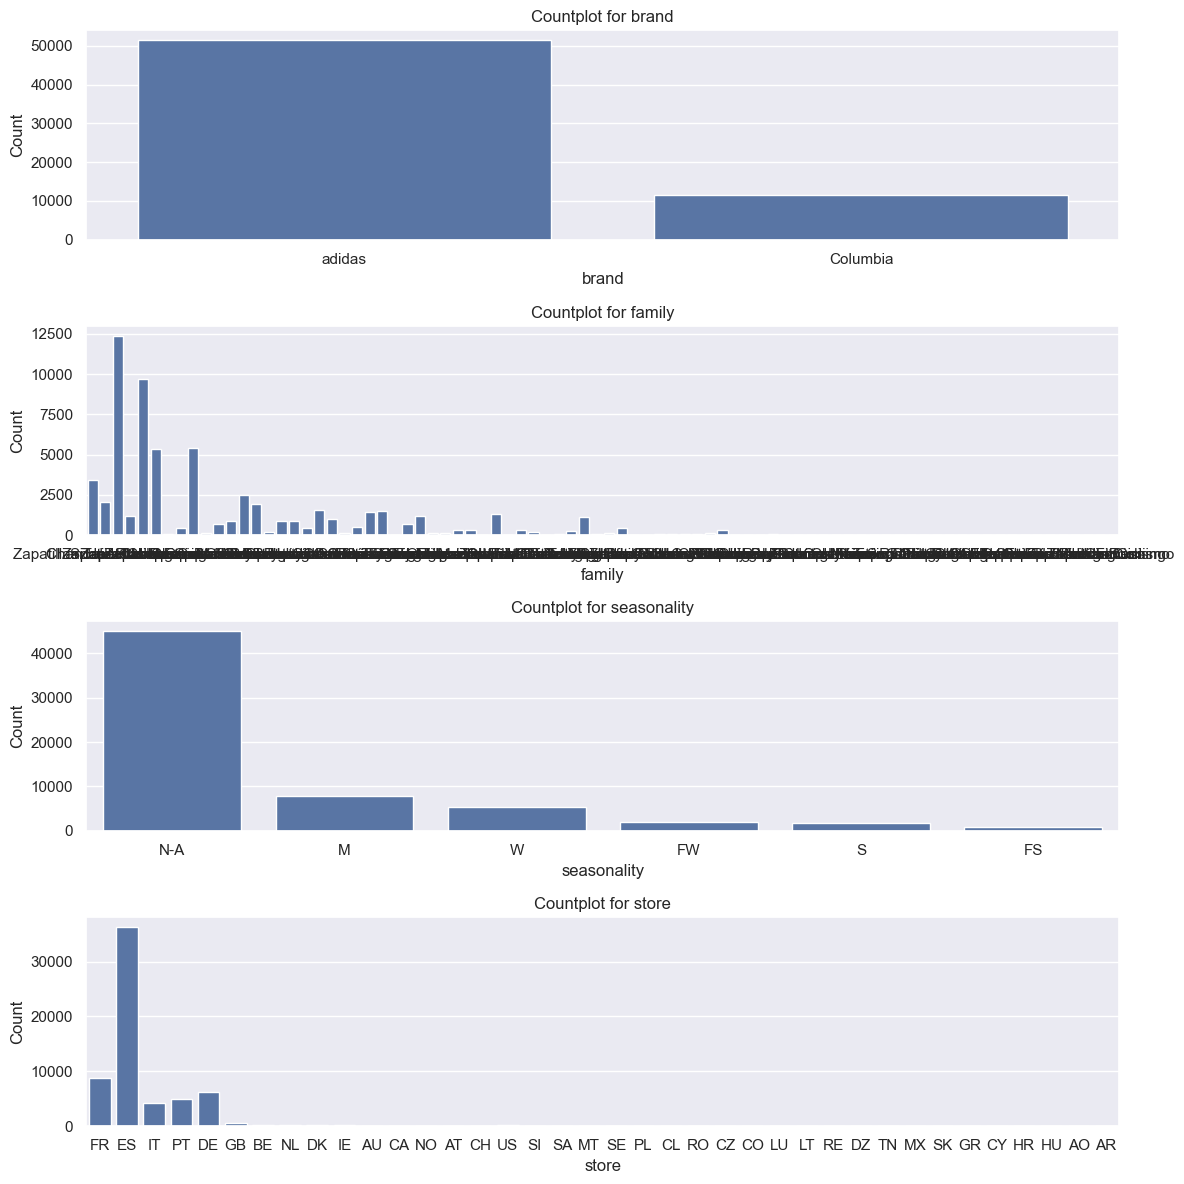

In [7]:
categorical_columns = ['brand', 'family', 'seasonality', 'store']

plt.figure(figsize=(12, 3 * len(categorical_columns)))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    sns.countplot(x=col, data=df)
    plt.title(f"Countplot for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()

# Show the plots
plt.show()

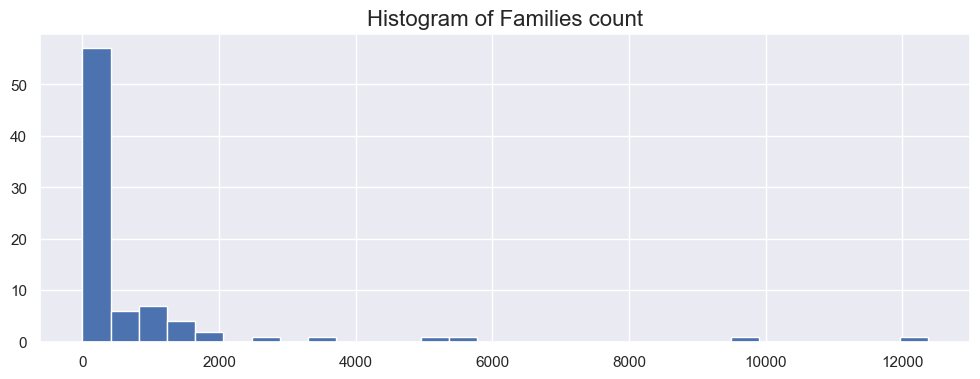

In [8]:
ax = df['family'].value_counts().hist(bins=30, figsize=(12, 4))
ax.set_title("Histogram of Families count", fontsize=16)
plt.show()

In [9]:
df[(df['family'] == 'Bañadores Natación') & (df['brand'] == 'adidas')]

,product_id,date,store,quantity,seasonality,brand,family,pvp
4617,435ADDF37CAD417484CEB2FE3534DDC9,2021-06-28,IT,1.0,FS,adidas,Bañadores Natación,65.00
4618,435ADDF37CAD417484CEB2FE3534DDC9,2021-04-05,ES,1.0,FS,adidas,Bañadores Natación,65.00
4619,435ADDF37CAD417484CEB2FE3534DDC9,2021-06-25,ES,1.0,FS,adidas,Bañadores Natación,65.00
4620,435ADDF37CAD417484CEB2FE3534DDC9,2021-08-27,DE,1.0,FS,adidas,Bañadores Natación,65.00
4621,435ADDF37CAD417484CEB2FE3534DDC9,2021-04-06,PT,1.0,FS,adidas,Bañadores Natación,65.00
...,...,...,...,...,...,...,...,...
62237,B2D053B1EAC34A47AE17A46315647F42,2023-12-31,ES,1.0,FS,adidas,Bañadores Natación,179.95
62339,A5AC84C6E2BA4422895A4F928DE7F2AE,2023-10-09,ES,1.0,N-A,adidas,Bañadores Natación,129.95
62359,4169374B896743AFB738D401B7B694D8,2022-05-09,ES,1.0,N-A,adidas,Bañadores Natación,25.00
62605,8398396710644457B589F8E29C823CB7,2024-09-01,ES,1.0,FS,adidas,Bañadores Natación,140.00


In [10]:
df.groupby(['family', 'brand'])['seasonality'].nunique()#.value_counts()

family                 brand   
Bañadores Natación     Columbia    1
                       adidas      3
Bañadores Urban        adidas      1
Botas Urban            Columbia    1
                       adidas      1
                                  ..
Zapatillas Urban       Columbia    1
                       adidas      1
Zapatillas de montaña  Columbia    1
                       adidas      2
Zuecos Urban           adidas      1
Name: seasonality, Length: 109, dtype: int64

In [11]:
df.groupby(['family', 'brand'])['store'].nunique()

family                 brand   
Bañadores Natación     Columbia     2
                       adidas      20
Bañadores Urban        adidas       3
Botas Urban            Columbia     2
                       adidas       2
                                   ..
Zapatillas Urban       Columbia     5
                       adidas      25
Zapatillas de montaña  Columbia    11
                       adidas      20
Zuecos Urban           adidas       5
Name: store, Length: 109, dtype: int64

## 3. Time series inspection

#### Revenues and quantities

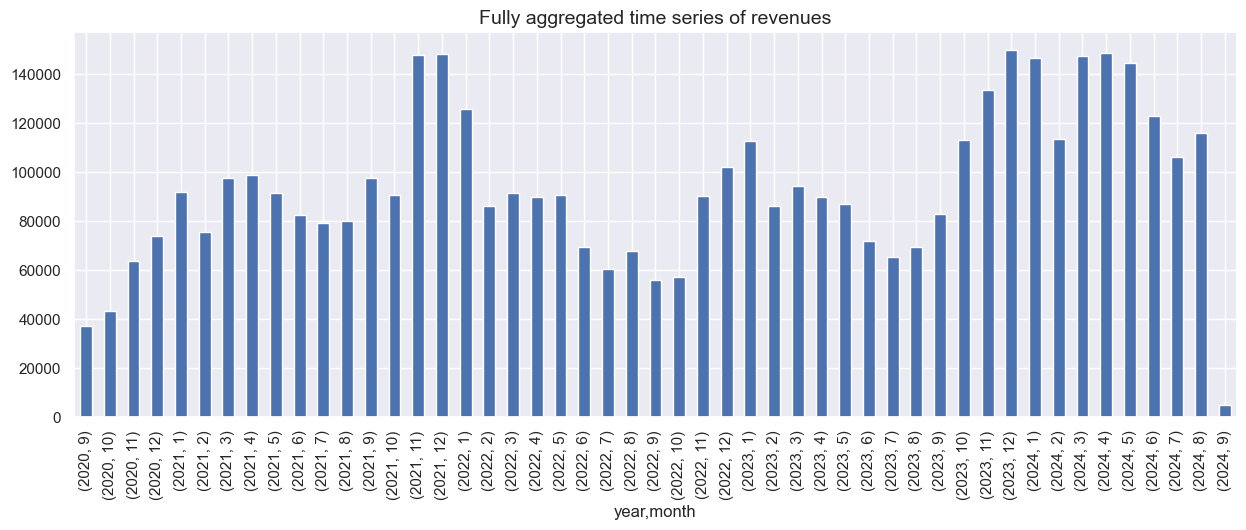

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
ax = df.groupby(['year', 'month'])['pvp'].sum().plot(kind='bar', figsize=(15, 5))
ax.set_title("Fully aggregated time series of revenues", fontsize=14)
plt.show()

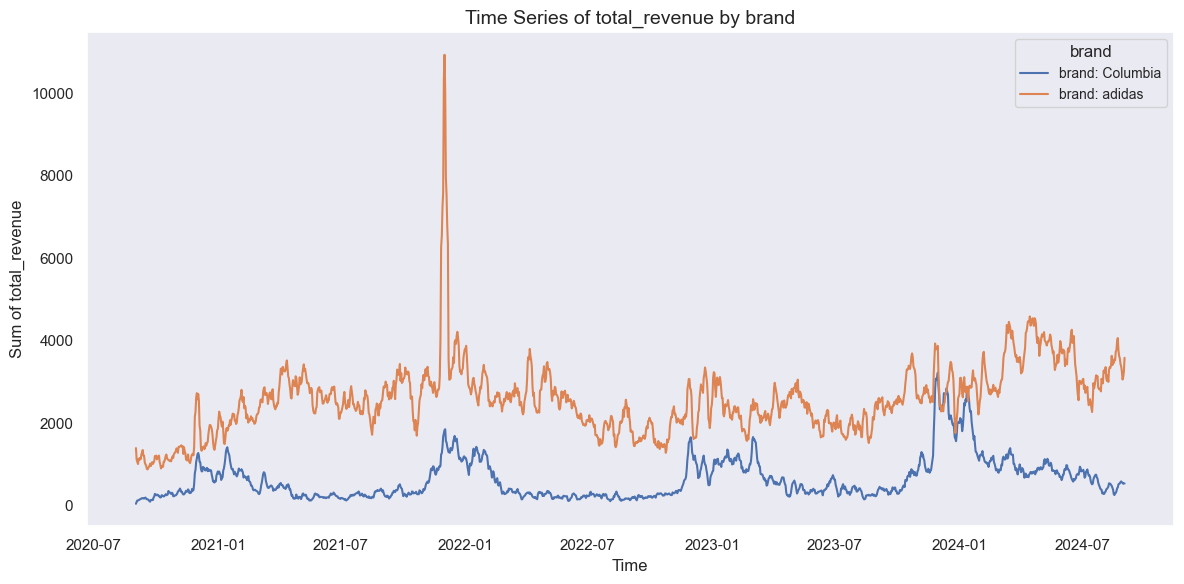

In [13]:
utils_plots.plot_time_series_by_category(df_grouped, category_col='brand', target_col='total_revenue', time_col='date', agg_func='sum', window=7)

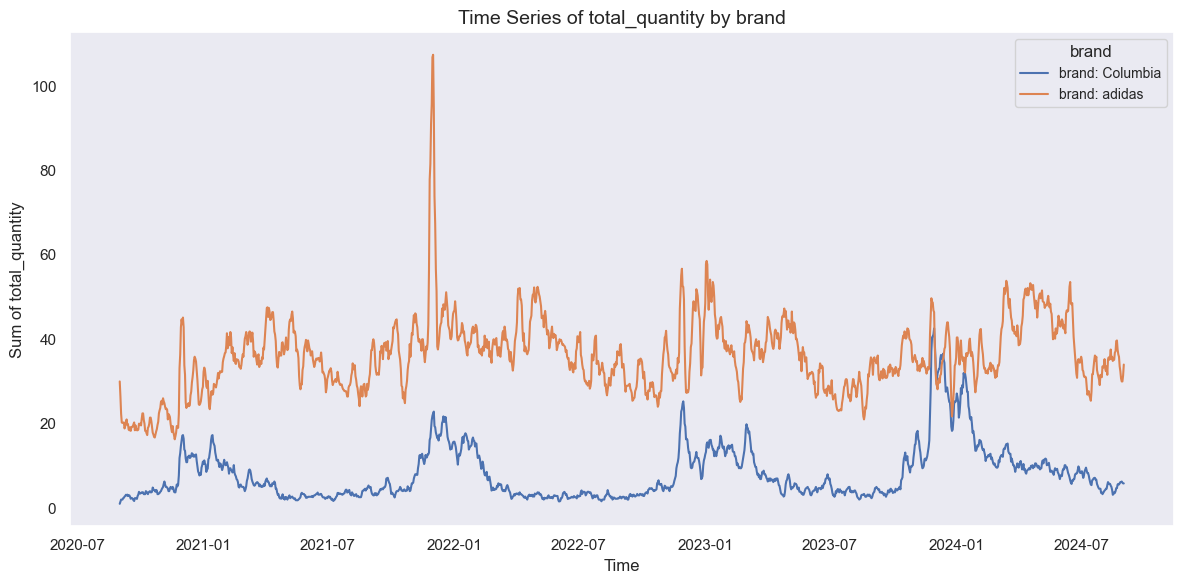

In [14]:
utils_plots.plot_time_series_by_category(df_grouped, category_col='brand', target_col='total_quantity', time_col='date', agg_func='sum', window=7)

### Seasonalities

If we exclude N-A, there is a visible pattern of seasonalities. As expected.  
It's quite visible for the time series that "S" and "FS" follow a different seasonal pattern.  
This could have an impact on our forecast: if we aggregate data (suppose at the weekly/monthly level), then we will lose the info about the specific seasonaliti of a product.  
This means that we won't be able to use 'seasonality' as a feature directly and we will mix products with different patterns.  
It could make sense to train separate models for each category in the seasonality column.

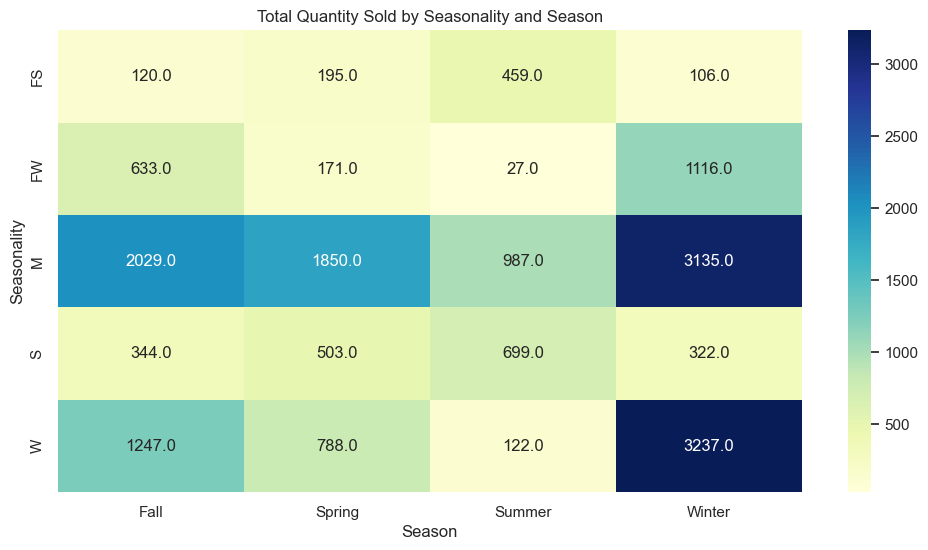

In [15]:
# Extract month from the date
df['month'] = df['date'].dt.month

# Map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)
df_temp = df[df['seasonality'] != 'N-A']   

# Seasonality vs Season heatmap
seasonality_sales = df_temp.groupby(['seasonality', 'season']).agg(total_quantity=('quantity', 'sum')).reset_index()

seasonality_sales_pivot = seasonality_sales.pivot(index='seasonality', columns='season', values='total_quantity')

plt.figure(figsize=(12, 6))
sns.heatmap(seasonality_sales_pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Total Quantity Sold by Seasonality and Season')
plt.xlabel('Season')
plt.ylabel('Seasonality')
plt.show()

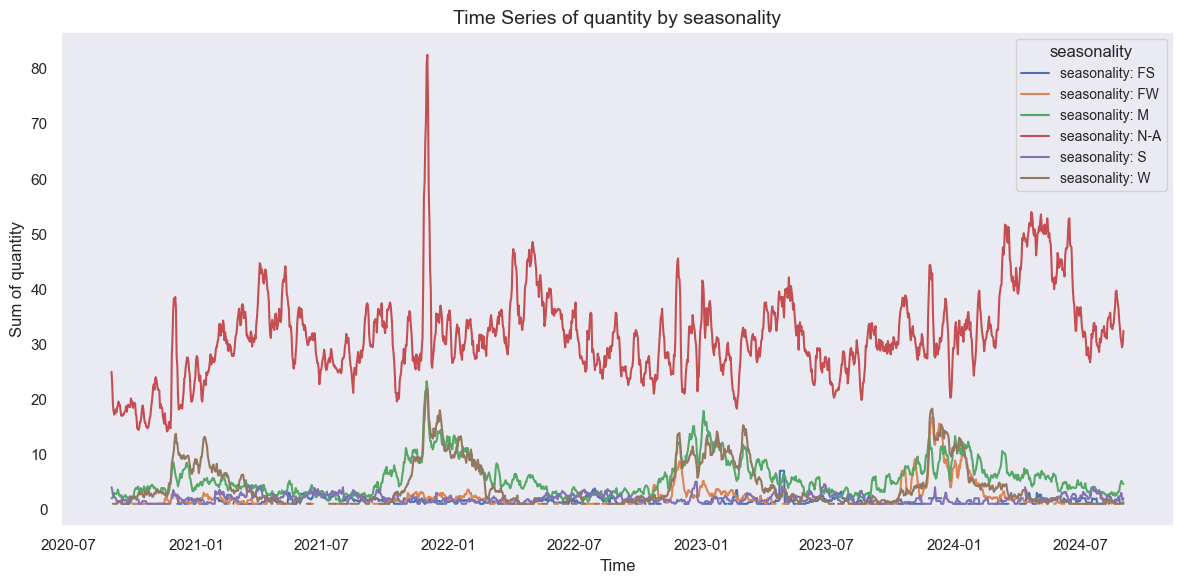

In [16]:
utils_plots.plot_time_series_by_category(df, category_col='seasonality', target_col='quantity', time_col='date', agg_func='sum', window=7)

/Users/matteogiaretti/Python/use_case_deporvillage/utils/utils_plots.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])


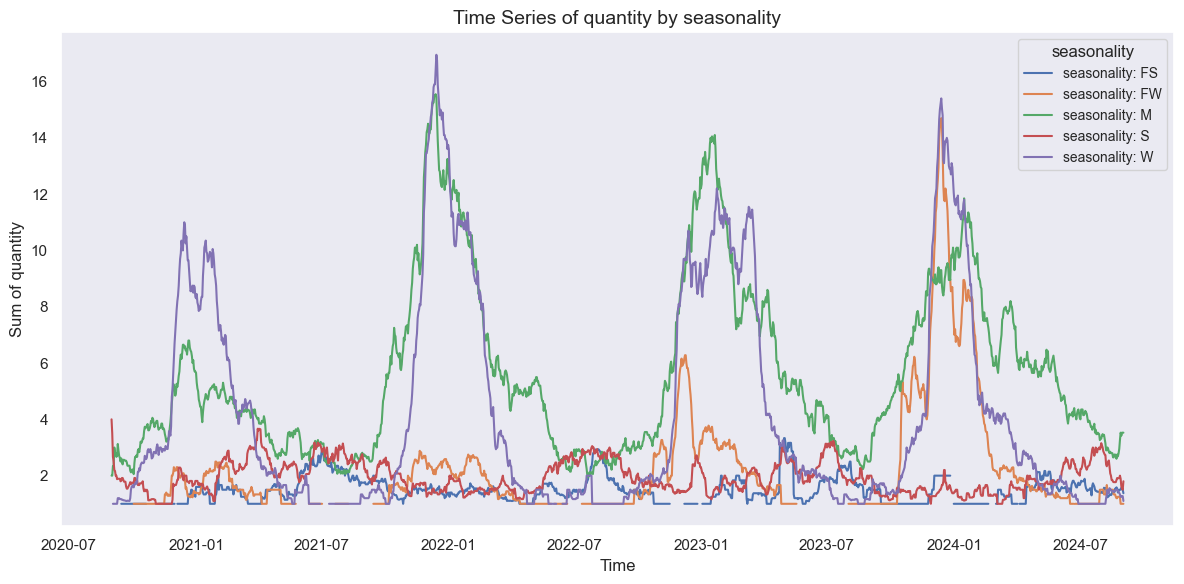

In [17]:
df_temp = df[df['seasonality'] != 'N-A']
utils_plots.plot_time_series_by_category(df_temp, category_col='seasonality', target_col='quantity', time_col='date', agg_func='sum', window=20)

### Families

Since most of the family names are like this 'Zapatillas Trail Running', i.e. clothing_article + clothing_type, we can thing about splitting names to generate new features.  
Few observations:  
- Most of the spikes in the time series are generated by single products.

In [23]:
processor = ExtractFamilyFeatures()
df = processor(df) 

In [24]:
df

,product_id,date,store,quantity,seasonality,brand,family,pvp,year,month,season,clothing_type,sport_category,outlet_flag
0,883A4A2507184C5483FDC9FC7E48240B,2021-03-22,FR,1.0,N-A,adidas,Zapatillas Trail Running,130.00,2021,3,Spring,zapatillas,trail running,0
1,883A4A2507184C5483FDC9FC7E48240B,2021-03-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.00,2021,3,Spring,zapatillas,trail running,0
2,883A4A2507184C5483FDC9FC7E48240B,2021-08-27,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.00,2021,8,Summer,zapatillas,trail running,0
3,883A4A2507184C5483FDC9FC7E48240B,2021-06-24,ES,1.0,N-A,adidas,Zapatillas Trail Running,130.00,2021,6,Summer,zapatillas,trail running,0
4,883A4A2507184C5483FDC9FC7E48240B,2021-03-05,IT,1.0,N-A,adidas,Zapatillas Trail Running,130.00,2021,3,Spring,zapatillas,trail running,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62809,F438E725631D4B72819E4B2E567B7C14,2023-03-29,ES,1.0,N-A,Columbia,Zapatillas de montaña,99.95,2023,3,Spring,zapatillas,de montaña,0
62810,70732AD67F17451387FC89F1E576A525,2021-07-05,ES,1.0,N-A,Columbia,Zapatillas de montaña,80.00,2021,7,Summer,zapatillas,de montaña,0
62811,622EF83B0C284654A91A8DBFD176471D,2021-07-10,FR,1.0,N-A,Columbia,Zapatillas de montaña,74.95,2021,7,Summer,zapatillas,de montaña,0
62812,8349E74BA6BC4940A06DBD3088332A4C,2023-03-03,ES,1.0,N-A,Columbia,Zapatillas de montaña,35.00,2023,3,Spring,zapatillas,de montaña,0


In [25]:
df['family'].value_counts()

family
Zapatillas Urban              12373
Zapatillas Running             9696
Chaquetas Outdoor              5435
Zapatillas de montaña          5342
Zapatillas Trail Running       3453
                              ...  
Culotes Ciclismo                  2
Headwear Training                 2
Outlet Zapatillas Ciclismo        1
Headwear Running                  1
Maillots Ciclismo                 1
Name: count, Length: 82, dtype: int64

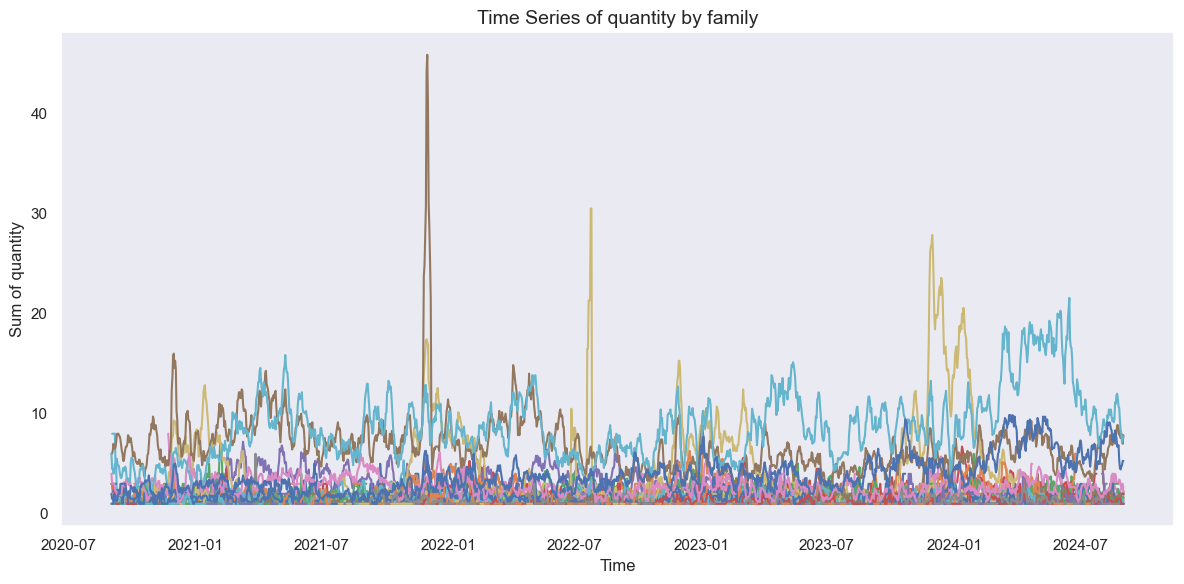

In [19]:
utils_plots.plot_time_series_by_category(df, category_col='family', target_col='quantity', time_col='date', agg_func='sum', window=7, legend=False)

/Users/matteogiaretti/Python/use_case_deporvillage/utils/utils_plots.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])


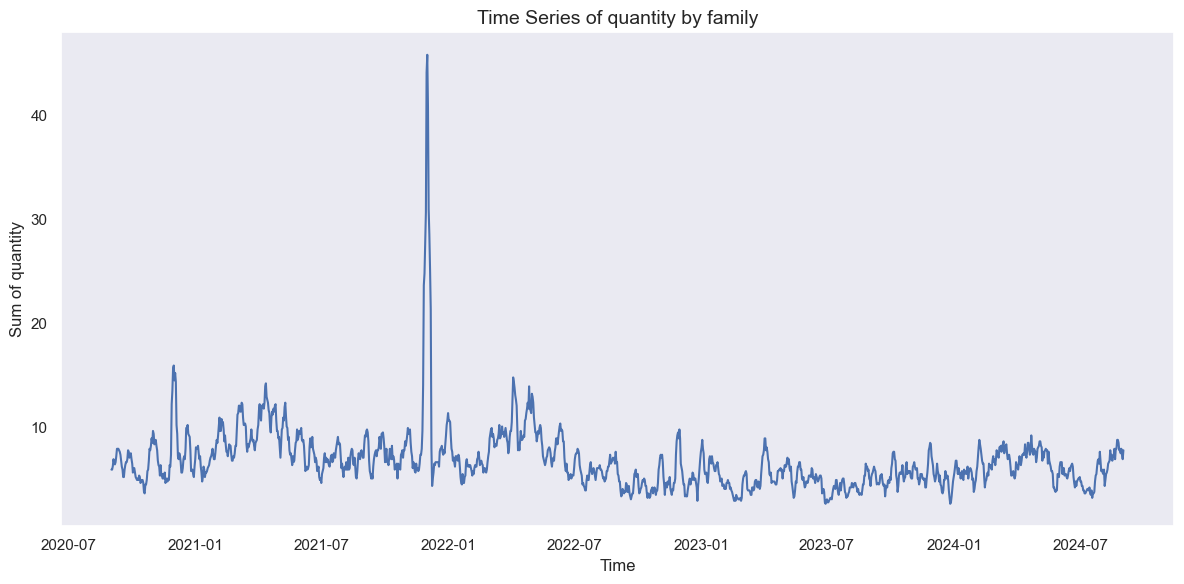

In [27]:
df_temp = df[df['family'] == 'Zapatillas Running']
utils_plots.plot_time_series_by_category(df_temp, category_col='family', target_col='quantity', time_col='date', agg_func='sum', window=7, legend=False)

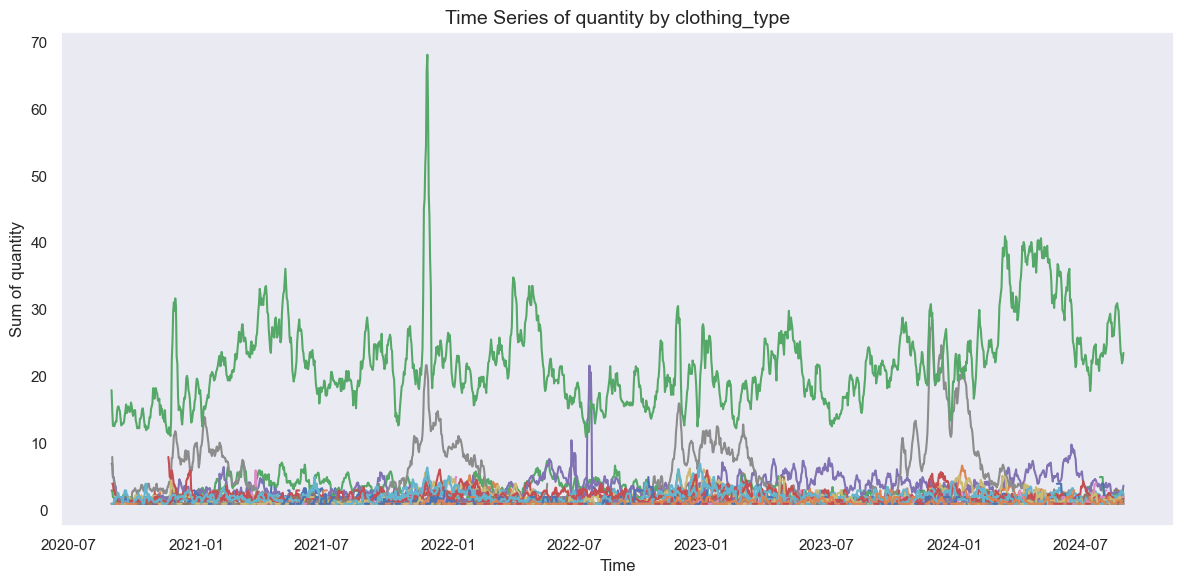

In [30]:
utils_plots.plot_time_series_by_category(df, category_col='clothing_type', target_col='quantity', time_col='date', agg_func='sum', window=7, legend=False)

/Users/matteogiaretti/Python/use_case_deporvillage/utils/utils_plots.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_col] = pd.to_datetime(df[time_col])


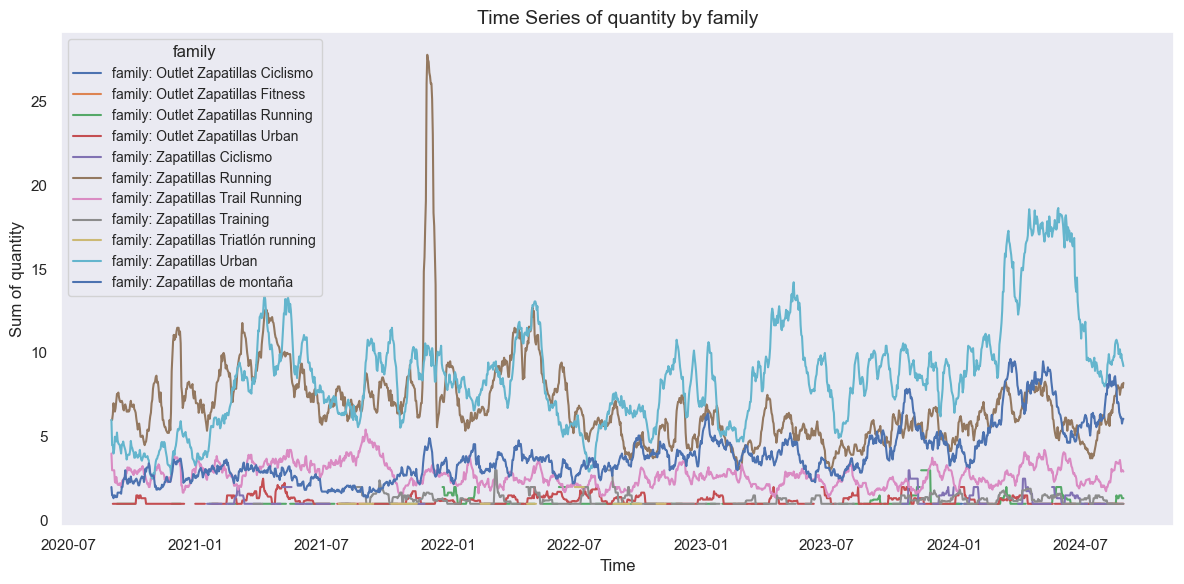

In [36]:
df_temp = df[df['clothing_type'] == 'zapatillas']
utils_plots.plot_time_series_by_category(df_temp, category_col='family', target_col='quantity', time_col='date', agg_func='sum', window=14)